In [1]:
!pip install yfinance --quiet
!pip install ta --quiet
!pip install plotly --quiet

[*********************100%%**********************]  4 of 4 completed


2/2 [==============================] - 1s 11ms/step
Training with 50 years - MAE: 0.062168703446068105
2/2 [==============================] - 1s 12ms/step
Training with 40 years - MAE: 0.06491005308077848
2/2 [==============================] - 1s 13ms/step
Training with 30 years - MAE: 0.06299604728316771


2/2 [==============================] - 1s 13ms/step
Training with 20 years - MAE: 0.06456046377294924


2/2 [==============================] - 1s 14ms/step
Training with 10 years - MAE: 0.06619516966150617


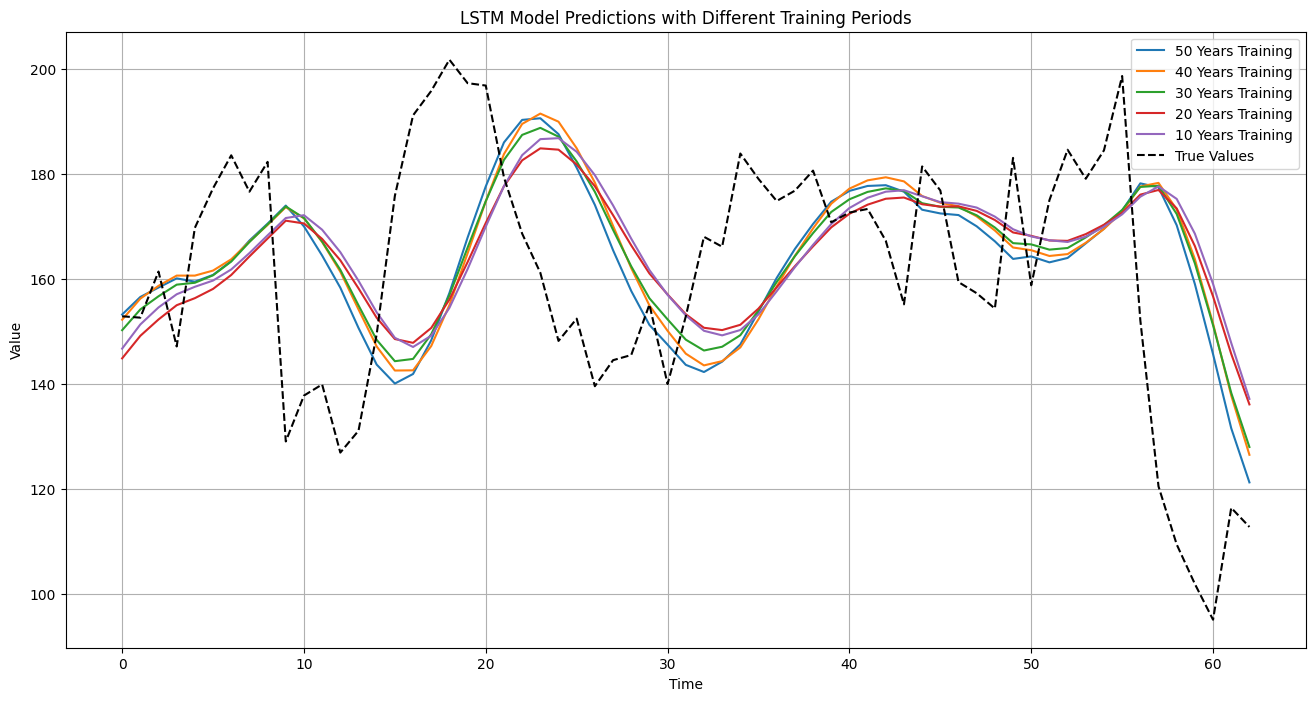

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Download the data
start_date = '1974-01-01'
end_date = '2024-08-10'
all_stocks = ['BA', 'MSI', 'DE', 'SPGI']
df = yf.download(all_stocks, start=start_date, end=end_date)['Adj Close']
df = df.reset_index()

# Prepare the BA stock data
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df['BA']

# Preprocess Data
def preprocess_data(df, window_size):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df.values.reshape(-1, 1))

    X, y = [], []
    for i in range(window_size, len(df)):
        X.append(scaled_data[i-window_size:i, 0])
        y.append(scaled_data[i, 0])

    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # Reshape for LSTM [samples, time steps, features]

    return X, y, None

# Define LSTM Model
def create_lstm_model(units, dropout, learning_rate):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=False, input_shape=(90, 1)))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_absolute_error')
    return model

# Train and evaluate each model configuration
def train_and_evaluate(X_train, y_train, X_test, y_test, hyperparams, epochs, batch_size, strategy):
    with strategy.scope():
        model = create_lstm_model(hyperparams['units'], hyperparams['dropout'], hyperparams['learning_rate'])
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
        predictions = model.predict(X_test)
    mae = mean_absolute_error(y_test, predictions)
    return mae, predictions

# Configuration for the LSTM model
config = {'units': 150, 'dropout': 0.2, 'learning_rate': 0.001}

# Possible values for epochs and batch size
epochs = 20
batch_size = 1024  # Increased batch size to leverage TPU

# Use TPU strategy for parallel processing
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # Remove .connect()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)  # Explicitly initialize TPU
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.MirroredStrategy()

# Varying training periods
training_years = [50, 40, 30, 20, 10]
results = {}

# Test data (2024)
test_start = '2024-01-01'
test_end = '2024-08-10'
df_test = df[test_start:test_end]

for years in training_years:
    # Define the training period
    train_end = pd.to_datetime('2023-12-31')
    train_start = train_end - pd.DateOffset(years=years)

    df_train = df[train_start:train_end]

    # Prepare data
    window_size = 90
    X_train, y_train, scaler = preprocess_data(df_train, window_size)
    X_test, y_test, _ = preprocess_data(df_test, window_size)

    # Train and evaluate
    mae, predictions = train_and_evaluate(X_train, y_train, X_test, y_test, config, epochs, batch_size, strategy)

    results[years] = {
        'mae': mae,
        'predictions': predictions
    }
    print(f"Training with {years} years - MAE: {mae}")

# Plot predictions for comparison
plt.figure(figsize=(16, 8))

for years, result in results.items():
    plt.plot(scaler.inverse_transform(result['predictions']), label=f"{years} Years Training")

plt.plot(scaler.inverse_transform(y_test.reshape(-1, 1)), label="True Values", color='black', linestyle='dashed')
plt.title("LSTM Model Predictions with Different Training Periods")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


 If you are using a 20-year training period, you will use data from 20 years before the end date of your training set. The end date of the training data is fixed at 2023-12-31, and the start date is calculated by subtracting 20 years from this end date.

In [3]:
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go

# Download the data
start_date = '1974-01-01'
end_date = '2024-08-10'
all_stocks = ['BA', 'MSI', 'DE', 'SPGI']
df = yf.download(all_stocks, start=start_date, end=end_date)['Adj Close']
df = df.reset_index()

# Prepare the BA stock data
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df['BA']

# Preprocess Data
def preprocess_data(df, window_size):
    #scaler = MinMaxScaler(feature_range=(0, 1))
    #scaled_data = scaler.fit_transform(df.values.reshape(-1, 1))
    scaled_data = df.values.reshape(-1, 1)

    X, y, dates = [], [], []
    for i in range(window_size, len(df)):
        X.append(scaled_data[i-window_size:i, 0])
        y.append(scaled_data[i, 0])
        dates.append(df.index[i])  # Collect dates for plotting

    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # Reshape for LSTM [samples, time steps, features]

    return X, y, None, dates

# Define LSTM Model
def create_lstm_model(units, dropout, learning_rate):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=False, input_shape=(90, 1)))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_absolute_error')
    return model

# Train and evaluate each model configuration
def train_and_evaluate(X_train, y_train, X_test, y_test, hyperparams, epochs, batch_size, strategy):
    with strategy.scope():
        model = create_lstm_model(hyperparams['units'], hyperparams['dropout'], hyperparams['learning_rate'])
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
        predictions = model.predict(X_test)
    mae = mean_absolute_error(y_test, predictions)
    return mae, predictions

# Configuration for the LSTM model
config = {'units': 150, 'dropout': 0.2, 'learning_rate': 0.001}

# Possible values for epochs and batch size
batch_sizes = [32, 64, 128, 256]
epochs_list = [20, 30, 40, 50]

# Use TPU strategy for parallel processing
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.MirroredStrategy()

# Varying training periods
training_years = [50, 40, 30, 20, 10]
results = {}

# Test data (2024)
test_start = '2024-01-01'
test_end = '2024-08-10'
df_test = df[test_start:test_end]

# Grid Search for best batch size and epochs
best_config = None
best_mae = float('inf')
best_predictions = None
best_dates = None

for years in training_years:
    train_end = pd.to_datetime('2023-12-31')
    train_start = train_end - pd.DateOffset(years=years)
    df_train = df[train_start:train_end]

    window_size = 90
    X_train, y_train, scaler, train_dates = preprocess_data(df_train, window_size)
    X_test, y_test, _, test_dates = preprocess_data(df_test, window_size)

    for batch_size in batch_sizes:
        for epochs in epochs_list:
            mae, predictions = train_and_evaluate(X_train, y_train, X_test, y_test, config, epochs, batch_size, strategy)
            if mae < best_mae:
                best_mae = mae
                best_config = {'years': years, 'batch_size': batch_size, 'epochs': epochs}
                best_predictions = predictions
                best_dates = test_dates
            print(f"Training with {years} years, batch_size {batch_size}, epochs {epochs} - MAE: {mae}")

print(f"Best Configuration - Years: {best_config['years']}, Batch Size: {best_config['batch_size']}, Epochs: {best_config['epochs']} - MAE: {best_mae}")




[*********************100%%**********************]  4 of 4 completed


2/2 [==============================] - 1s 12ms/step
Training with 50 years, batch_size 32, epochs 20 - MAE: 4.257183983212426
2/2 [==============================] - 1s 12ms/step
Training with 50 years, batch_size 32, epochs 30 - MAE: 3.7632247682601685
2/2 [==============================] - 1s 14ms/step
Training with 50 years, batch_size 32, epochs 40 - MAE: 3.905127389090402
2/2 [==============================] - 1s 12ms/step
Training with 50 years, batch_size 32, epochs 50 - MAE: 5.8211822509765625


2/2 [==============================] - 1s 12ms/step
Training with 50 years, batch_size 64, epochs 20 - MAE: 5.022611345563616


2/2 [==============================] - 1s 13ms/step
Training with 50 years, batch_size 64, epochs 30 - MAE: 4.054184202163938
2/2 [==============================] - 1s 11ms/step
Training with 50 years, batch_size 64, epochs 40 - MAE: 3.3371768527560763
2/2 [==============================] - 1s 12ms/step
Training with 50 years, batch_size 64, epochs 50 - MAE: 3.3927496047247026
2/2 [==============================] - 1s 12ms/step
Training with 50 years, batch_size 128, epochs 20 - MAE: 3.3715067061166915
2/2 [==============================] - 2s 15ms/step
Training with 50 years, batch_size 128, epochs 30 - MAE: 3.0749371241009427
2/2 [==============================] - 1s 12ms/step
Training with 50 years, batch_size 128, epochs 40 - MAE: 3.312468998015873
2/2 [==============================] - 1s 12ms/step
Training with 50 years, batch_size 128, epochs 50 - MAE: 3.778871324327257
2/2 [==============================] - 1s 13ms/step
Training with 50 years, batch_size 256, epochs 20 - MAE: 5

KeyboardInterrupt: 

We included a parameter to check for overfitting in the code by monitoring the training and validation losses during the model training process. Overfitting occurs when the model performs well on the training data but poorly on the validation data, indicating that it has learned the training data too well (including noise) and is not generalizing to unseen data.

Steps :

- Split the Training Data: Split the training data into training and validation sets.
- Track Training and Validation Losses: Use these sets to track the training and validation losses during the model fitting.
- Early Stopping (Optional): Implement early stopping if the validation loss stops decreasing.

In [2]:
# Include overfitting parameter


import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go

# Download the data
start_date = '1974-01-01'
end_date = '2024-08-10'
all_stocks = ['BA', 'MSI', 'DE', 'SPGI']
df = yf.download(all_stocks, start=start_date, end=end_date)['Adj Close']
df = df.reset_index()

# Prepare the BA stock data
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df['BA']

# Preprocess Data
def preprocess_data(df, window_size):
    scaled_data = df.values.reshape(-1, 1)

    X, y, dates = [], [], []
    for i in range(window_size, len(df)):
        X.append(scaled_data[i-window_size:i, 0])
        y.append(scaled_data[i, 0])
        dates.append(df.index[i])  # Collect dates for plotting

    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # Reshape for LSTM [samples, time steps, features]

    return X, y, None, dates

# Define LSTM Model
def create_lstm_model(units, dropout, learning_rate):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=False, input_shape=(90, 1)))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_absolute_error')
    return model

# Train and evaluate each model configuration
def train_and_evaluate(X_train, y_train, X_val, y_val, X_test, y_test, hyperparams, epochs, batch_size, strategy):
    with strategy.scope():
        model = create_lstm_model(hyperparams['units'], hyperparams['dropout'], hyperparams['learning_rate'])

        # Adding EarlyStopping callback to prevent overfitting
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            verbose=0,
            callbacks=[early_stopping]
        )

        train_loss = history.history['loss']
        val_loss = history.history['val_loss']
        predictions = model.predict(X_test)

    mae = mean_absolute_error(y_test, predictions)

    return mae, predictions, train_loss, val_loss

# Configuration for the LSTM model
config = {'units': 150, 'dropout': 0.2, 'learning_rate': 0.001}

# Possible values for epochs and batch size
batch_sizes = [32]
# batch_sizes = [32, 64, 128, 256]
epochs_list = [50, 75]

# Use TPU strategy for parallel processing
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.MirroredStrategy()

# Varying training periods
training_years = [50, 40, 30, 20, 10]
results = {}

# Test data (2024)
test_start = '2024-01-01'
test_end = '2024-08-10'
df_test = df[test_start:test_end]

# Grid Search for best batch size and epochs
best_config = None
best_mae = float('inf')
best_predictions = None
best_dates = None

for years in training_years:
    train_end = pd.to_datetime('2023-12-31')
    train_start = train_end - pd.DateOffset(years=years)
    df_train = df[train_start:train_end]

    # Split into training and validation sets (80/20 split)
    val_size = int(len(df_train) * 0.2)
    df_val = df_train[-val_size:]
    df_train = df_train[:-val_size]

    window_size = 90
    X_train, y_train, scaler, train_dates = preprocess_data(df_train, window_size)
    X_val, y_val, _, val_dates = preprocess_data(df_val, window_size)
    X_test, y_test, _, test_dates = preprocess_data(df_test, window_size)

    for batch_size in batch_sizes:
        for epochs in epochs_list:
            mae, predictions, train_loss, val_loss = train_and_evaluate(
                X_train, y_train, X_val, y_val, X_test, y_test, config, epochs, batch_size, strategy)

            if mae < best_mae:
                best_mae = mae
                best_config = {'years': years, 'batch_size': batch_size, 'epochs': epochs}
                best_predictions = predictions
                best_dates = test_dates
            print(f"Training with {years} years, batch_size {batch_size}, epochs {epochs} - MAE: {mae}")
            print(f"Training Loss: {train_loss[-1]}, Validation Loss: {val_loss[-1]}")

print(f"Best Configuration - Years: {best_config['years']}, Batch Size: {best_config['batch_size']}, Epochs: {best_config['epochs']} - MAE: {best_mae}")


[*********************100%%**********************]  4 of 4 completed


2/2 [==============================] - 1s 11ms/step
Training with 50 years, batch_size 32, epochs 50 - MAE: 64.43504575699095
Training Loss: 0.8739925622940063, Validation Loss: 97.8362808227539
2/2 [==============================] - 1s 12ms/step
Training with 50 years, batch_size 32, epochs 75 - MAE: 67.29768541124132
Training Loss: 0.9050372838973999, Validation Loss: 98.2069320678711
2/2 [==============================] - 1s 14ms/step
Training with 40 years, batch_size 32, epochs 50 - MAE: 37.70195806594122
Training Loss: 1.4009931087493896, Validation Loss: 102.99502563476562


KeyboardInterrupt: 

## **No early stop**

In [ ]:
# Include overfitting parameter


import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go

# Download the data
start_date = '1974-01-01'
end_date = '2024-08-10'
all_stocks = ['BA', 'MSI', 'DE', 'SPGI']
df = yf.download(all_stocks, start=start_date, end=end_date)['Adj Close']
df = df.reset_index()

# Prepare the BA stock data
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df['BA']

# Preprocess Data
def preprocess_data(df, window_size):
    scaled_data = df.values.reshape(-1, 1)

    X, y, dates = [], [], []
    for i in range(window_size, len(df)):
        X.append(scaled_data[i-window_size:i, 0])
        y.append(scaled_data[i, 0])
        dates.append(df.index[i])  # Collect dates for plotting

    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # Reshape for LSTM [samples, time steps, features]

    return X, y, None, dates

# Define LSTM Model
def create_lstm_model(units, dropout, learning_rate):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=False, input_shape=(90, 1)))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_absolute_error')
    return model

# Train and evaluate each model configuration
def train_and_evaluate(X_train, y_train, X_val, y_val, X_test, y_test, hyperparams, epochs, batch_size, strategy):
    with strategy.scope():
        model = create_lstm_model(hyperparams['units'], hyperparams['dropout'], hyperparams['learning_rate'])

        # Adding EarlyStopping callback to prevent overfitting
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            verbose=0
        )

        train_loss = history.history['loss']
        val_loss = history.history['val_loss']
        predictions = model.predict(X_test)

    mae = mean_absolute_error(y_test, predictions)

    return mae, predictions, train_loss, val_loss

# Configuration for the LSTM model
config = {'units': 150, 'dropout': 0.2, 'learning_rate': 0.001}

# Possible values for epochs and batch size
batch_sizes = [32]
# batch_sizes = [32, 64, 128, 256]
# epochs_list = [20, 40, 50, 75]
epochs_list = [20, 40]

# Use TPU strategy for parallel processing
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.MirroredStrategy()

# Varying training periods
training_years = [50, 40, 30, 20, 10]
results = {}

# Test data (2024)
test_start = '2024-01-01'
test_end = '2024-08-10'
df_test = df[test_start:test_end]

# Grid Search for best batch size and epochs
best_config = None
best_mae = float('inf')
best_predictions = None
best_dates = None

for years in training_years:
    train_end = pd.to_datetime('2023-12-31')
    train_start = train_end - pd.DateOffset(years=years)
    df_train = df[train_start:train_end]

    # Split into training and validation sets (80/20 split)
    val_size = int(len(df_train) * 0.2)
    df_val = df_train[-val_size:]
    df_train = df_train[:-val_size]

    window_size = 90
    X_train, y_train, scaler, train_dates = preprocess_data(df_train, window_size)
    X_val, y_val, _, val_dates = preprocess_data(df_val, window_size)
    X_test, y_test, _, test_dates = preprocess_data(df_test, window_size)

    for batch_size in batch_sizes:
        for epochs in epochs_list:
            mae, predictions, train_loss, val_loss = train_and_evaluate(
                X_train, y_train, X_val, y_val, X_test, y_test, config, epochs, batch_size, strategy)

            if mae < best_mae:
                best_mae = mae
                best_config = {'years': years, 'batch_size': batch_size, 'epochs': epochs}
                best_predictions = predictions
                best_dates = test_dates
            print(f"Training with {years} years, batch_size {batch_size}, epochs {epochs} - MAE: {mae}")
            print(f"Training Loss: {train_loss[-1]}, Validation Loss: {val_loss[-1]}")

print(f"Best Configuration - Years: {best_config['years']}, Batch Size: {best_config['batch_size']}, Epochs: {best_config['epochs']} - MAE: {best_mae}")


[*********************100%%**********************]  4 of 4 completed


2/2 [==============================] - 1s 13ms/step
Training with 50 years, batch_size 32, epochs 20 - MAE: 72.19625503297836
Training Loss: 0.9397805333137512, Validation Loss: 101.55365753173828
2/2 [==============================] - 1s 15ms/step
Training with 50 years, batch_size 32, epochs 40 - MAE: 67.61116306365483
Training Loss: 0.8723379373550415, Validation Loss: 97.34104919433594
2/2 [==============================] - 1s 12ms/step
Training with 40 years, batch_size 32, epochs 20 - MAE: 48.09584069630456
Training Loss: 1.4430267810821533, Validation Loss: 100.53462219238281
2/2 [==============================] - 1s 11ms/step
Training with 40 years, batch_size 32, epochs 40 - MAE: 41.995837014818946
Training Loss: 1.3502299785614014, Validation Loss: 96.09446716308594


2/2 [==============================] - 1s 12ms/step
Training with 30 years, batch_size 32, epochs 20 - MAE: 16.424755035884797
Training Loss: 3.8608317375183105, Validation Loss: 87.28302001953125


2/2 [==============================] - 1s 13ms/step
Training with 30 years, batch_size 32, epochs 40 - MAE: 5.894396342928448
Training Loss: 2.4703776836395264, Validation Loss: 42.797061920166016
2/2 [==============================] - 1s 13ms/step
Training with 20 years, batch_size 32, epochs 20 - MAE: 3.576114957294767
Training Loss: 21.526376724243164, Validation Loss: 10.449106216430664
2/2 [==============================] - 1s 12ms/step
Training with 20 years, batch_size 32, epochs 40 - MAE: 3.5605410621279763
Training Loss: 5.15615177154541, Validation Loss: 4.28275203704834
2/2 [==============================] - 1s 13ms/step
Training with 10 years, batch_size 32, epochs 20 - MAE: 44.96896313864087
Training Loss: 86.92398071289062, Validation Loss: 54.48067855834961


In [ ]:

import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go

# Download the data
start_date = '1974-01-01'
end_date = '2024-08-10'
all_stocks = ['BA', 'MSI', 'DE', 'SPGI']
df = yf.download(all_stocks, start=start_date, end=end_date)['Adj Close']
df = df.reset_index()

# Prepare the BA stock data
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df['BA']

# Preprocess Data
def preprocess_data(df, window_size):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df.values.reshape(-1, 1))

    X, y, dates = [], [], []
    for i in range(window_size, len(df)):
        X.append(scaled_data[i-window_size:i, 0])
        y.append(scaled_data[i, 0])
        dates.append(df.index[i])  # Collect dates for plotting

    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # Reshape for LSTM [samples, time steps, features]

    return X, y, scaler, dates

# Define LSTM Model
def create_lstm_model(units, dropout, learning_rate):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=False, input_shape=(90, 1)))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_absolute_error')
    return model

# Train and evaluate each model configuration
def train_and_evaluate(X_train, y_train, X_test, y_test, hyperparams, epochs, batch_size, strategy):
    with strategy.scope():
        model = create_lstm_model(hyperparams['units'], hyperparams['dropout'], hyperparams['learning_rate'])
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
        predictions = model.predict(X_test)
    mae = mean_absolute_error(y_test, predictions)
    return mae, predictions

# Configuration for the LSTM model
config = {'units': 150, 'dropout': 0.2, 'learning_rate': 0.001}

# Possible values for epochs and batch size
batch_sizes = [32]
epochs_list = [30, 50, 100]

# Use TPU strategy for parallel processing
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.MirroredStrategy()

# Varying training periods
training_years = [50, 40, 30, 20, 10]
results = {}

# Test data (2024)
test_start = '2024-01-01'
test_end = '2024-08-10'
df_test = df[test_start:test_end]

# Grid Search for best batch size and epochs
best_config = None
best_mae = float('inf')
best_predictions = None
best_dates = None

for years in training_years:
    train_end = pd.to_datetime('2023-12-31')
    train_start = train_end - pd.DateOffset(years=years)
    df_train = df[train_start:train_end]

    window_size = 90
    X_train, y_train, scaler, train_dates = preprocess_data(df_train, window_size)
    X_test, y_test, _, test_dates = preprocess_data(df_test, window_size)

    for batch_size in batch_sizes:
        for epochs in epochs_list:
            mae, predictions = train_and_evaluate(X_train, y_train, X_test, y_test, config, epochs, batch_size, strategy)
            if mae < best_mae:
                best_mae = mae
                best_config = {'years': years, 'batch_size': batch_size, 'epochs': epochs}
                best_predictions = predictions
                best_dates = test_dates
            print(f"Training with {years} years, batch_size {batch_size}, epochs {epochs} - MAE: {mae}")

print(f"Best Configuration - Years: {best_config['years']}, Batch Size: {best_config['batch_size']}, Epochs: {best_config['epochs']} - MAE: {best_mae}")


In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go

# Define the best configuration
best_years = 50
best_batch_size = 32
best_epochs = 40

# Download the data
start_date = '1974-01-01'
end_date = '2024-08-10'
all_stocks = ['BA', 'MSI', 'DE', 'SPGI']
df = yf.download(all_stocks, start=start_date, end=end_date)['Adj Close']
df = df.reset_index()

test_start = '2024-01-01'
test_end = '2024-08-10'

# Prepare the BA stock data
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df['BA']

# Preprocess Data
def preprocess_data(df, window_size):
    #scaler = MinMaxScaler(feature_range=(0, 1))
    #scaled_data = scaler.fit_transform(df.values.reshape(-1, 1))

    scaled_data = df.values.reshape(-1, 1)

    X, y, dates = [], [], []
    for i in range(window_size, len(df)):
        X.append(scaled_data[i-window_size:i, 0])
        y.append(scaled_data[i, 0])
        dates.append(df.index[i])  # Collect dates for plotting

    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # Reshape for LSTM [samples, time steps, features]

    return X, y, None, dates

# Define LSTM Model
def create_lstm_model(units, dropout, learning_rate):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=False, input_shape=(90, 1)))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_absolute_error')
    return model

# Train and evaluate each model configuration
def train_and_evaluate(X_train, y_train, X_test, y_test, hyperparams, epochs, batch_size, strategy):
    with strategy.scope():
        model = create_lstm_model(hyperparams['units'], hyperparams['dropout'], hyperparams['learning_rate'])
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
        predictions = model.predict(X_test)
    mae = mean_absolute_error(y_test, predictions)
    return mae, predictions

# Configuration for the LSTM model
config = {'units': 150, 'dropout': 0.2, 'learning_rate': 0.001}

# Use TPU strategy for parallel processing
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.MirroredStrategy()

# Prepare the data using the best configuration
train_end = pd.to_datetime('2023-12-31')
train_start = train_end - pd.DateOffset(years=best_years)
df_train = df[train_start:train_end]
df_test = df[test_start:test_end]

# Prepare data
window_size = 90
X_train, y_train, scaler, train_dates = preprocess_data(df_train, window_size)
X_test, y_test, _, test_dates = preprocess_data(df_test, window_size)

# Train the model using the best configuration
model = create_lstm_model(units=150, dropout=0.2, learning_rate=0.001)
model.fit(X_train, y_train, epochs=best_epochs, batch_size=best_batch_size, verbose=0)

# Make predictions on the test data
predictions = model.predict(X_test)

# Inverse transform the predictions and true values using the scaler
#predictions = scaler.inverse_transform(predictions)
#y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate MAE
mae = mean_absolute_error(y_test, predictions)
print(f"MAE on Test Data: {mae}")

# Create a Plotly plot to show the predictions and actual values
fig = go.Figure()

# Plot actual values
fig.add_trace(go.Scatter(x=test_dates, y=y_test.flatten(), mode='lines', name='Actual Values', line=dict(color='black', dash='dash')))

# Plot predictions
fig.add_trace(go.Scatter(x=test_dates, y=predictions.flatten(), mode='lines', name=f'Predictions (MAE: {mae:.4f})', line=dict(color='blue')))

# Add layout details
fig.update_layout(
    title="LSTM Model Predictions vs Actual Values",
    xaxis_title="Date",
    yaxis_title="Stock Price",
    legend_title="Legend",
    hovermode="x unified"
)

# Show the plot
fig.show()


[*********************100%%**********************]  4 of 4 completed


2/2 [==============================] - 0s 31ms/step
MAE on Test Data: 5.102068704272074


In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go

# Define the best configuration
best_years = 50
best_batch_size = 32
best_epochs = 40

# Download the data
start_date = '1974-01-01'
end_date = '2024-08-10'
all_stocks = ['BA', 'MSI', 'DE', 'SPGI']
df = yf.download(all_stocks, start=start_date, end=end_date)['Adj Close']
df = df.reset_index()

test_start = '2024-01-01'
test_end = '2024-08-10'

# Prepare the BA stock data
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df['BA']
# Preprocess Data
def preprocess_data(df, window_size):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df.values.reshape(-1, 1))

    X, y, dates = [], [], []
    for i in range(window_size, len(df)):
        X.append(scaled_data[i-window_size:i, 0])
        y.append(scaled_data[i, 0])
        dates.append(df.index[i])  # Collect dates for plotting

    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # Reshape for LSTM [samples, time steps, features]

    return X, y, scaler, dates

# Define LSTM Model
def create_lstm_model(units, dropout, learning_rate):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=False, input_shape=(90, 1)))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_absolute_error')
    return model

# Train and evaluate each model configuration
def train_and_evaluate(X_train, y_train, X_test, y_test, hyperparams, epochs, batch_size, strategy):
    with strategy.scope():
        model = create_lstm_model(hyperparams['units'], hyperparams['dropout'], hyperparams['learning_rate'])
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
        predictions = model.predict(X_test)
    mae = mean_absolute_error(y_test, predictions)
    return mae, predictions

# Configuration for the LSTM model
config = {'units': 150, 'dropout': 0.2, 'learning_rate': 0.001}



# Use TPU strategy for parallel processing
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.MirroredStrategy()
# Prepare the data using the best configuration
train_end = pd.to_datetime('2023-12-31')
train_start = train_end - pd.DateOffset(years=best_years)
df_train = df[train_start:train_end]
df_test = df[test_start:test_end]

# Prepare data
window_size = 90
X_train, y_train, scaler, train_dates = preprocess_data(df_train, window_size)
X_test, y_test, _, test_dates = preprocess_data(df_test, window_size)

# Define LSTM Model
model = create_lstm_model(units=150, dropout=0.2, learning_rate=0.001)

# Train the model using the best configuration
model.fit(X_train, y_train, epochs=best_epochs, batch_size=best_batch_size, verbose=0)

# Make predictions on the test data
predictions = model.predict(X_test)

# Calculate MAE
mae = mean_absolute_error(y_test, predictions)
print(f"MAE on Test Data: {mae}")

# Inverse transform the predictions and true values
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Create a Plotly plot to show the predictions and actual values
fig = go.Figure()

# Plot actual values
fig.add_trace(go.Scatter(x=test_dates, y=y_test.flatten(), mode='lines', name='Actual Values', line=dict(color='black', dash='dash')))

# Plot predictions
fig.add_trace(go.Scatter(x=test_dates, y=predictions.flatten(), mode='lines', name=f'Predictions (MAE: {mae:.4f})', line=dict(color='blue')))

# Add layout details
fig.update_layout(
    title="LSTM Model Predictions vs Actual Values",
    xaxis_title="Date",
    yaxis_title="Stock Price",
    legend_title="Legend",
    hovermode="x unified"
)

# Show the plot
fig.show()

[*********************100%%**********************]  4 of 4 completed


2/2 [==============================] - 0s 31ms/step
MAE on Test Data: 0.032684231949529644


In [ ]:
# Create a Plotly plot to show the predictions and actual values
fig = go.Figure()

# Plot actual values
fig.add_trace(go.Scatter(x=test_dates, y=y_test.flatten(), mode='lines', name='Actual Values', line=dict(color='black', dash='dash')))

# Plot predictions
fig.add_trace(go.Scatter(x=test_dates, y=predictions.flatten(), mode='lines', name=f'Predictions (MAE: {mae:.4f})', line=dict(color='blue')))

# Add layout details
fig.update_layout(
    title="LSTM Model Predictions vs Actual Values",
    xaxis_title="Date",
    yaxis_title="Stock Price",
    legend_title="Legend",
    hovermode="x unified"
)

# Show the plot
fig.show()

In [ ]:
y_test.flatten()

array([7.43298382e+01, 7.39897005e+01, 8.52640749e+01, 6.69432073e+01,
       9.59553879e+01, 1.05626065e+02, 1.13693120e+02, 1.04799932e+02,
       1.12089423e+02, 4.37140349e+01, 5.49398393e+01, 5.76612375e+01,
       4.09925626e+01, 4.63382190e+01, 6.99561732e+01, 1.03779445e+02,
       1.23461011e+02, 1.29438447e+02, 1.37068076e+02, 1.31333712e+02,
       1.30750502e+02, 1.08298894e+02, 9.45460447e+01, 8.49725071e+01,
       6.83039064e+01, 7.37467027e+01, 5.72238858e+01, 6.35900295e+01,
       6.48535146e+01, 7.71970944e+01, 5.77584514e+01, 7.42812683e+01,
       9.37684812e+01, 9.13386508e+01, 1.14130472e+02, 1.07910112e+02,
       1.02515885e+02, 1.05042930e+02, 1.09951160e+02, 9.73160869e+01,
       9.96972733e+01, 1.00572051e+02, 9.27965639e+01, 7.72456643e+01,
       1.10971722e+02, 1.05091500e+02, 8.26884606e+01, 7.99670625e+01,
       7.62251030e+01, 1.13061340e+02, 8.19109713e+01, 1.02710313e+02,
       1.15053819e+02, 1.07958682e+02, 1.14908035e+02, 1.33083193e+02,
      

In [ ]:
!pip install yfinance
!pip install ta
!pip install plotly

import pandas as pd
import numpy as np
import yfinance as yf
import json
import ta
import matplotlib.pyplot as pl
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, RegressorMixin


start_date = '1974-01-01'
end_date = '2024-08-10'

all_stocks = ['BA', 'MSI', 'DE', 'SPGI']


# Download the data
df = yf.download(all_stocks, start=start_date, end=end_date)['Adj Close']
df = df.reset_index()


df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df['BA']
# Display the 1st 5 records
df.head(5)

[*********************100%%**********************]  4 of 4 completed


,BA
Date,
1974-01-02,0.130799
1974-01-03,0.132121
1974-01-04,0.130799
1974-01-07,0.128157
1974-01-08,0.122872


31/31 [==============================] - 1s 28ms/step
Random Search - Best MSE: 0.008978173023176312 with Epochs: 30 and Batch Size: 32
31/31 [==============================] - 1s 26ms/step
Bayesian Optimization - Best MSE: 0.008952231470879304 with Epochs: 30 and Batch Size: 32
31/31 [==============================] - 1s 13ms/step
Hyperband - Best MSE: 0.009093773994503306 with Epochs: 30 and Batch Size: 32
31/31 [==============================] - 1s 10ms/step
Grid Search - Best MSE: 0.008998857047315007 with Epochs: 20 and Batch Size: 64


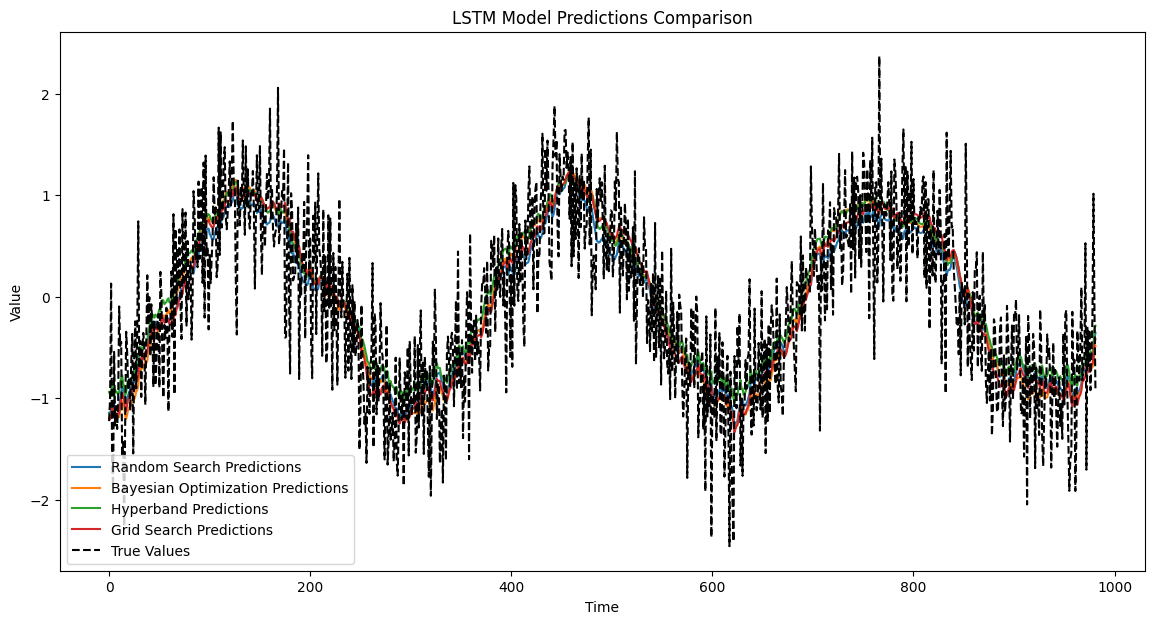

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Assume your dataset is loaded into a DataFrame 'df'
# df = pd.read_csv('your_dataset.csv')

# Example synthetic dataset creation (to be replaced with your actual data)
np.random.seed(42)
data = np.sin(np.linspace(0, 100, 5000)) + np.random.normal(scale=0.5, size=5000)
df = pd.DataFrame(data, columns=['value'])

# Preprocess Data
def preprocess_data(df, window_size):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df)

    X, y = [], []
    for i in range(window_size, len(df)):
        X.append(scaled_data[i-window_size:i, 0])
        y.append(scaled_data[i, 0])

    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # Reshape for LSTM [samples, time steps, features]

    return X, y, scaler

# Define LSTM Model
def create_lstm_model(units, dropout, learning_rate):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=False, input_shape=(90, 1)))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

# Train and evaluate each model configuration
def train_and_evaluate(X_train, y_train, X_test, y_test, hyperparams, epochs, batch_size):
    model = create_lstm_model(hyperparams['units'], hyperparams['dropout'], hyperparams['learning_rate'])
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    return mse, predictions

# Configuration for each hypertuning method
configs = {
    'Random Search': {'units': 150, 'dropout': 0.2, 'learning_rate': 0.001},
    'Bayesian Optimization': {'units': 150, 'dropout': 0.3, 'learning_rate': 0.001},
    'Hyperband': {'units': 100, 'dropout': 0.1, 'learning_rate': 0.01},
    'Grid Search': {'units': 50, 'dropout': 0.2, 'learning_rate': 0.01},
}

# Define possible values for epochs and batch sizes to be tested
epoch_options = [30, 50, 100]
batch_size_options = [32, 64, 128]

# Prepare the data
window_size = 90
X, y, scaler = preprocess_data(df, window_size)

# Split the data into training and testing sets
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Evaluate each configuration
results = {}

for method, params in configs.items():
    best_mse = float('inf')
    best_config = None
    for epochs in epoch_options:
        for batch_size in batch_size_options:
            mse, predictions = train_and_evaluate(X_train, y_train, X_test, y_test, params, epochs, batch_size)
            if mse < best_mse:
                best_mse = mse
                best_config = {
                    'epochs': epochs,
                    'batch_size': batch_size,
                    'predictions': predictions
                }
    results[method] = {
        'mse': best_mse,
        'best_epochs': best_config['epochs'],
        'best_batch_size': best_config['batch_size'],
        'predictions': best_config['predictions']
    }
    print(f"{method} - Best MSE: {best_mse} with Epochs: {best_config['epochs']} and Batch Size: {best_config['batch_size']}")

# Plot predictions for comparison
plt.figure(figsize=(14, 7))

for method, result in results.items():
    plt.plot(scaler.inverse_transform(result['predictions']), label=f"{method} Predictions")

plt.plot(scaler.inverse_transform(y_test.reshape(-1, 1)), label="True Values", color='black', linestyle='dashed')
plt.title("LSTM Model Predictions Comparison")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show()


In [ ]:
result

{'mse': 0.008998857047315007,
 'best_epochs': 20,
 'best_batch_size': 64,
 'predictions': array([[0.23546104],
        [0.23571888],
        [0.23835136],
        [0.25771767],
        [0.25000656],
        [0.23890512],
        [0.24658716],
        [0.24516734],
        [0.24644208],
        [0.24431694],
        [0.24683061],
        [0.26316503],
        [0.2737941 ],
        [0.28385955],
        [0.27616554],
        [0.27040946],
        [0.25388652],
        [0.2509276 ],
        [0.2621458 ],
        [0.27160504],
        [0.27539644],
        [0.28009403],
        [0.27984834],
        [0.28537774],
        [0.2954704 ],
        [0.2878379 ],
        [0.29352432],
        [0.30463767],
        [0.30611974],
        [0.31510773],
        [0.3398496 ],
        [0.34206462],
        [0.34728822],
        [0.3444261 ],
        [0.34758157],
        [0.35358384],
        [0.35791284],
        [0.35413584],
        [0.35837147],
        [0.37197286],
        [0.37914985],
        [